In [ ]:
!pip install haversine

# Tasks Performed
* Loads & cleans your NYC taxi data from KaggleHub’s downloaded files

* Performs time-based EDA (hourly & weekday trends)

* Creates an interactive heatmap of pickup points (nyc_pickup_heatmap.html)

* Runs DBSCAN clustering on GPS coordinates to find pickup hotspots

* Gives insights like number of clusters and busiest zones


In [ ]:
#Imports
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import os

In [ ]:
import kagglehub

# Download the dataset folder locally
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/nyc-yellow-taxi-trip-data


In [ ]:
import os
import kagglehub
# List the files actually stored on your machine/Colab environment
print("Dataset files:", os.listdir(path))


Dataset files: ['yellow_tripdata_2016-01.csv', 'yellow_tripdata_2016-03.csv', 'yellow_tripdata_2016-02.csv', 'yellow_tripdata_2015-01.csv']


In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join(path, "yellow_tripdata_2016-01.csv"))
print(f"Initial shape: {df.shape}")
print(df.head())

Initial shape: (10906858, 19)
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2016-01-01 00:00:00   2016-01-01 00:00:00                2   
1         2  2016-01-01 00:00:00   2016-01-01 00:00:00                5   
2         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
3         2  2016-01-01 00:00:00   2016-01-01 00:00:00                1   
4         2  2016-01-01 00:00:00   2016-01-01 00:00:00                3   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.10        -73.990372        40.734695           1   
1           4.90        -73.980782        40.729912           1   
2          10.54        -73.984550        40.679565           1   
3           4.75        -73.993469        40.718990           1   
4           1.76        -73.960625        40.781330           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.981842  

In [ ]:
file_path = os.path.join(path, "yellow_tripdata_2016-01.csv")
import pandas as pd

cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "trip_distance"
]

df = pd.read_csv(file_path, usecols=cols)


In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,-73.981842,40.732407
1,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,-73.944473,40.716679
2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,-73.950272,40.788925
3,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,-73.962242,40.657333
4,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,-73.977264,40.758514


In [ ]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

In [ ]:
# drop rows with missing coordinates
df = df.dropna(subset=["pickup_latitude", "pickup_longitude",
                       "dropoff_latitude", "dropoff_longitude",
                       "tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [ ]:
lon_min, lon_max = -74.3, -73.6
lat_min, lat_max = 40.48, 40.93

mask = (
    df["pickup_longitude"].between(lon_min, lon_max) &
    df["pickup_latitude"].between(lat_min, lat_max) &
    df["dropoff_longitude"].between(lon_min, lon_max) &
    df["dropoff_latitude"].between(lat_min, lat_max)
)
df = df[mask].copy()
print("After bounding box:", df.shape)



After bounding box: (10714678, 8)


In [ ]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")
df = df.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

# remove zero-distance trivial trips or zero passenger if you want
df = df[df["trip_distance"] > 0]
df = df[df["passenger_count"] > 0]

# Feature engineering
print("After filtering trivial trips:", df.shape)
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_day"] = df["tpep_pickup_datetime"].dt.day
df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.day_name()


After filtering trivial trips: (10674718, 8)


In [ ]:
# compute haversine distance (more realistic than trip_distance sometimes)
from haversine import haversine, Unit

def haversine_km(row):
    return haversine(
        (row["pickup_latitude"], row["pickup_longitude"]),
        (row["dropoff_latitude"], row["dropoff_longitude"]),
        unit=Unit.KILOMETERS
    )

# Apply on a sample or vectorized for memory
sample_for_dist = df.sample(100_000, random_state=42) if len(df) > 300_000 else df
sample_for_dist["haversine_km"] = sample_for_dist.apply(haversine_km, axis=1)

# You can merge back or compute for entire df if RAM allows
# For now compute summary stats from sample
print("Haversine distance (sample) stats:")
print(sample_for_dist["haversine_km"].describe())

Haversine distance (sample) stats:
count    100000.000000
mean          3.368508
std           3.844033
min           0.000000
25%           1.221739
50%           2.050921
75%           3.776719
max          39.755996
Name: haversine_km, dtype: float64


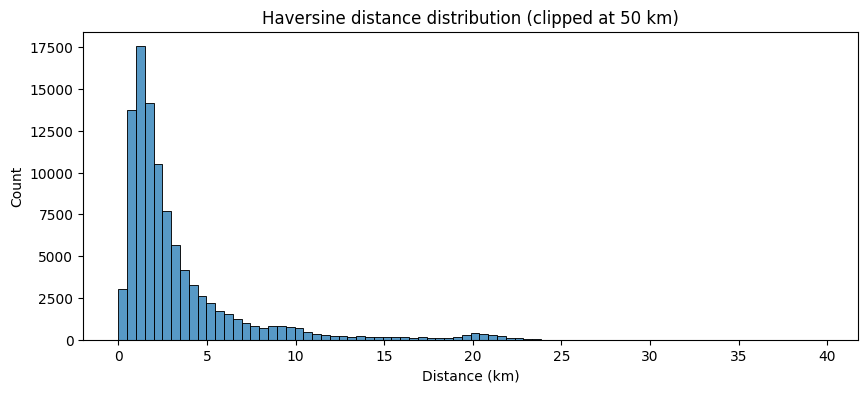

In [ ]:
#Trip distance analysis
# -------------------------
plt.figure(figsize=(10,4))
sns.histplot(sample_for_dist["haversine_km"].clip(upper=50), bins=80)
plt.title("Haversine distance distribution (clipped at 50 km)")
plt.xlabel("Distance (km)")
plt.show()

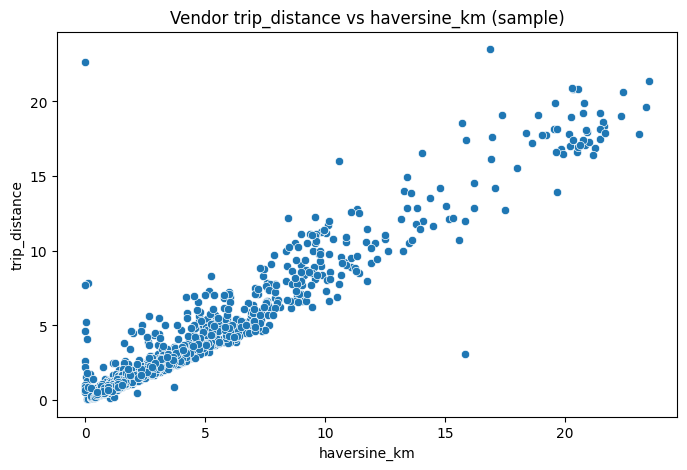

In [ ]:

# relationship between trip_distance (vendor) and haversine
if "trip_distance" in sample_for_dist.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="haversine_km", y="trip_distance", data=sample_for_dist.sample(2000))
    plt.title("Vendor trip_distance vs haversine_km (sample)")
    plt.show()

# **Start visualizations**

Folium Heatmap for pickups

Seaborn histplots for time trends

DBSCAN clustering for hotspots

/tmp/ipython-input-2173991565.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pickup_hour", data=df, palette="viridis")


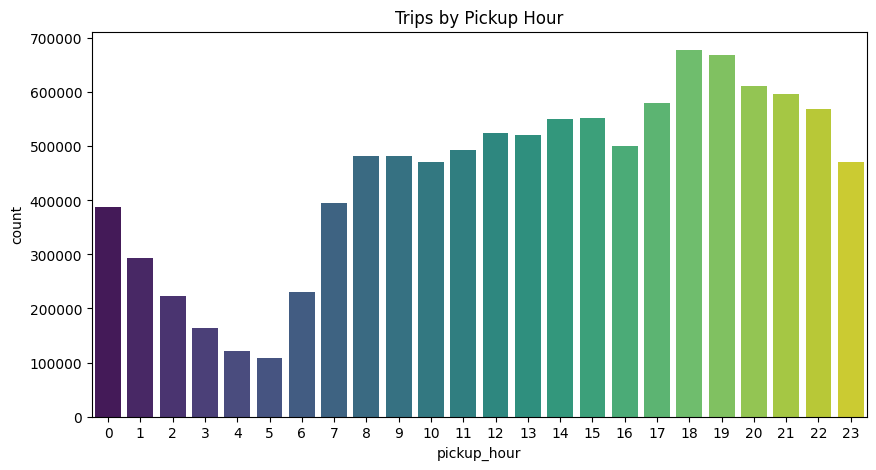

/tmp/ipython-input-2173991565.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pickup_weekday", data=df, order=[


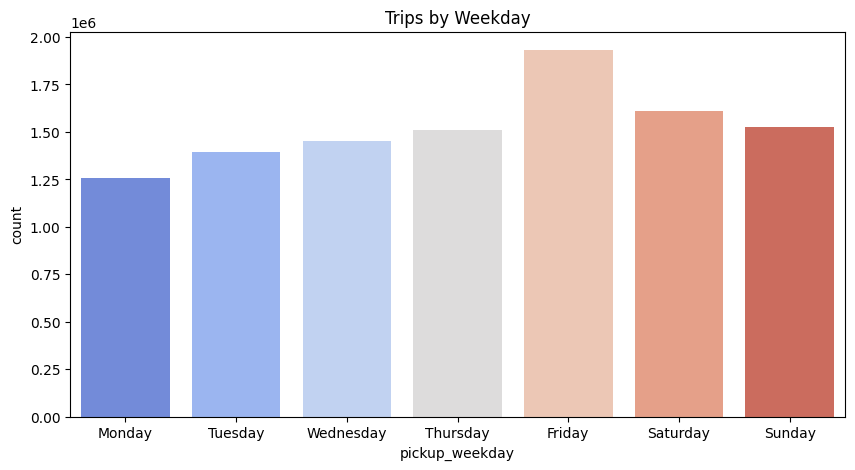

In [ ]:
#Temporal Trends
plt.figure(figsize=(10,5))
sns.countplot(x="pickup_hour", data=df, palette="viridis")
plt.title("Trips by Pickup Hour")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x="pickup_weekday", data=df, order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
], palette="coolwarm")
plt.title("Trips by Weekday")
plt.show()

In [ ]:
# Geospatial Heatmap of Pickups
sample_df = df.sample(5000, random_state=42)

m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
heat_data = list(zip(sample_df["pickup_latitude"], sample_df["pickup_longitude"]))
HeatMap(heat_data).add_to(m)

m.save("nyc_pickup_heatmap.html")
print("Heatmap saved as nyc_pickup_heatmap.html")

Heatmap saved as nyc_pickup_heatmap.html


In [ ]:
plot_sample = df.sample(7000, random_state=42)

m_pick = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
HeatMap(list(zip(plot_sample["pickup_latitude"], plot_sample["pickup_longitude"])), radius=8).add_to(m_pick)
m_pick.save("nyc_pickup_heatmap.html")
print("Saved nyc_pickup_heatmap.html")

m_drop = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
HeatMap(list(zip(plot_sample["dropoff_latitude"], plot_sample["dropoff_longitude"])), radius=8).add_to(m_drop)
m_drop.save("nyc_dropoff_heatmap.html")
print("Saved nyc_dropoff_heatmap.html")


Saved nyc_pickup_heatmap.html
Saved nyc_dropoff_heatmap.html


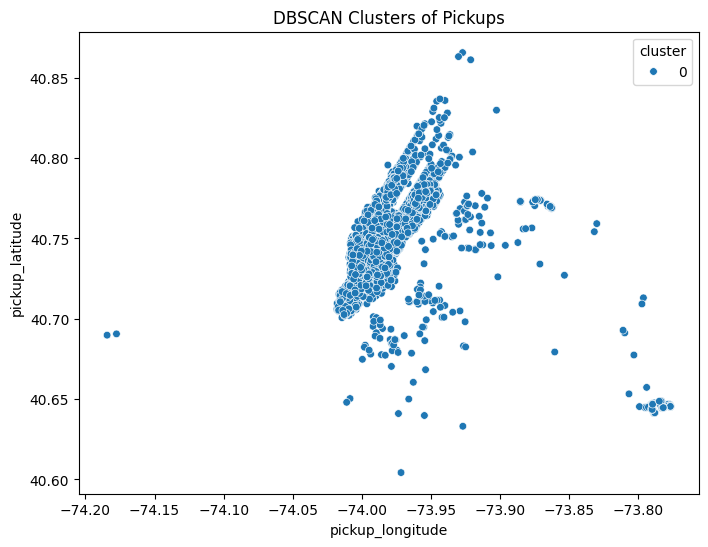

In [ ]:
# Clustering Hotspots with DBSCAN
coords = sample_df[["pickup_latitude", "pickup_longitude"]].values

db = DBSCAN(eps=0.01, min_samples=20, metric='haversine').fit(np.radians(coords))
sample_df["cluster"] = db.labels_

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="pickup_longitude", y="pickup_latitude",
    hue="cluster", data=sample_df, palette="tab10", legend="full", s=30
)
plt.title("DBSCAN Clusters of Pickups")
plt.show()

Clusters found (excluding noise): 8
   cluster  counts
0        0   92165
1        1    2508
2        2    2248
3       -1    1123
4        3     775


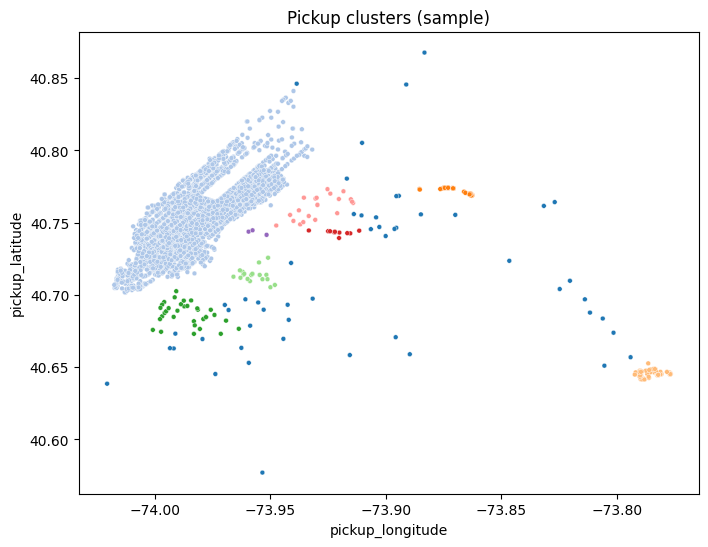

Saved nyc_cluster_centroids.html


In [ ]:
# Use a sample (or run on full data if resources allow)
cluster_sample = df.sample(100_000, random_state=42) if len(df) > 200_000 else df.copy()
coords = cluster_sample[["pickup_latitude", "pickup_longitude"]].to_numpy()

# DBSCAN with haversine metric requires radians and eps in radians.
# eps: approx 0.5 km -> convert: eps_rad = 0.5 / earth_radius_km
earth_radius_km = 6371.0
eps_km = 0.5  # change to tune cluster size
eps_rad = eps_km / earth_radius_km

db = DBSCAN(eps=eps_rad, min_samples=50, metric="haversine").fit(np.radians(coords))
cluster_sample["cluster"] = db.labels_

# number of clusters
n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print("Clusters found (excluding noise):", n_clusters)

# cluster counts
cluster_counts = cluster_sample["cluster"].value_counts().rename_axis("cluster").reset_index(name="counts")
print(cluster_counts.head())

# Compute cluster centroids (in lat/lon) for top clusters
top_clusters = cluster_counts[cluster_counts["cluster"] != -1].head(10)["cluster"].tolist()
centroids = {}
for c in top_clusters:
    sub = cluster_sample[cluster_sample["cluster"] == c]
    centroids[c] = (sub["pickup_latitude"].mean(), sub["pickup_longitude"].mean(), len(sub))
centroids

# Visualize clusters on scatter plot (small sample)
plt.figure(figsize=(8,6))
sns.scatterplot(x="pickup_longitude", y="pickup_latitude", hue="cluster",
                palette="tab20", data=cluster_sample.sample(5000, random_state=1), legend=False, s=12)
plt.title("Pickup clusters (sample)")
plt.show()

# Save a folium map with cluster centroids
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
# add centroid markers for top clusters
for c, (lat, lon, cnt) in centroids.items():
    folium.CircleMarker(location=[lat, lon],
                        radius=6,
                        popup=f"cluster {c} | count {cnt}",
                        color="red",
                        fill=True).add_to(map_clusters)
map_clusters.save("nyc_cluster_centroids.html")
print("Saved nyc_cluster_centroids.html")

# -------------------------
# 8) Assign clusters to full dataset (optional & recommended)
# -------------------------
# If you want clusters labels for whole dataset, you can use the DBSCAN model's core sample centers
# Simpler: Fit DBSCAN on sampled coords and then assign using nearest centroid from top clusters (fast approximation)
from sklearn.neighbors import KDTree
centroid_list = [(centroids[c][0], centroids[c][1]) for c in top_clusters]  # lat, lon
centroid_tree = KDTree(np.radians(centroid_list))
# query full df pickup coords to find closest centroid (if within threshold)
full_coords_rad = np.radians(df[["pickup_latitude", "pickup_longitude"]].to_numpy())
dist, idx = centroid_tree.query(full_coords_rad, k=1)
# convert radian distance to km
dist_km = dist.flatten() * earth_radius_km
assigned = np.where(dist_km <= eps_km, np.array(top_clusters)[idx.flatten()], -1)
df["approx_cluster"] = assigned  # -1 means not assigned to sampled top clusters

Busiest cluster id: 0
            tpep_pickup_datetime  count
pickup_date                            
2016-01-01            2016-01-01   8997
2016-01-02            2016-01-02   8731
2016-01-03            2016-01-03   7167
2016-01-04            2016-01-04   9563
2016-01-05            2016-01-05  11178


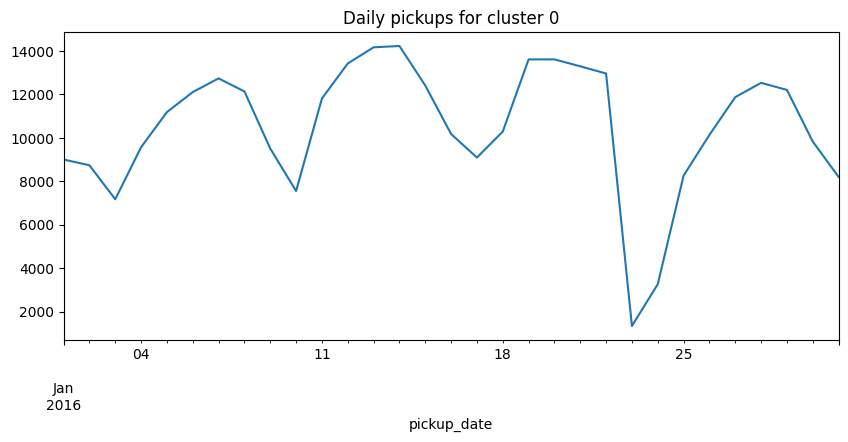

In [ ]:
#Time series: daily demand per cluster
# -------------------------
# pick busiest cluster (from cluster_sample counts)
busiest_cluster = cluster_counts[cluster_counts["cluster"] != -1].iloc[0]["cluster"]
print("Busiest cluster id:", busiest_cluster)

# Build daily counts using the approx_cluster column on full df
daily = (
    df[df["approx_cluster"] == busiest_cluster]
    .groupby(df["tpep_pickup_datetime"].dt.date) # Extract date from datetime column
    .size()
    .rename("count")
    .reset_index()
)
daily["tpep_pickup_datetime"] = pd.to_datetime(daily["tpep_pickup_datetime"]) # Convert to datetime objects
daily["pickup_date"] = daily["tpep_pickup_datetime"].dt.date # Extract date again for the new column
daily = daily.set_index("pickup_date").asfreq("D").fillna(0)  # fill missing days with 0
print(daily.head())

plt.figure(figsize=(10,4))
daily["count"].plot()
plt.title(f"Daily pickups for cluster {busiest_cluster}")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: divide by zero encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(

                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                   17
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                   0.000
Date:                           Sat, 16 Aug 2025   AIC                             10.000
Time:                                   03:33:12   BIC                               -inf
Sample:                               01-01-2016   HQIC                               nan
                                    - 01-17-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2914        nan        nan        nan         nan         nan
ma.L1         -0.3153        nan        nan

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


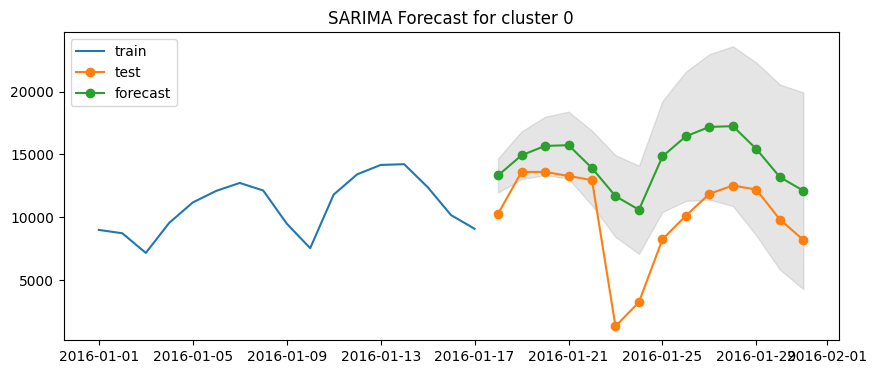

MAE on 14-day test: 4355.739184414978


In [ ]:
# Forecasting with SARIMA (example)
# -------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use a small train/test split
train = daily["count"][:-14]
test = daily["count"][-14:]

# Simple SARIMA (p,d,q) x (P,D,Q,s) example: try (1,1,1)x(1,1,1,7)
# NOTE: SARIMA modeling can be slow. Tune orders for speed.
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# Forecast
pred = res.get_forecast(steps=14)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Plot
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="train")
plt.plot(test.index, test, label="test", marker="o")
plt.plot(pred_mean.index, pred_mean, label="forecast", marker="o")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="grey", alpha=0.2)
plt.legend()
plt.title(f"SARIMA Forecast for cluster {busiest_cluster}")
plt.show()

# Compute simple error metric
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, pred_mean)
print("MAE on 14-day test:", mae)

##Obtained:
* EDA plots for temporal patterns

* Interactive HTML map of NYC hotspots

* Clustered scatter plots for geolocation patterns